## Import modules

In [29]:
import math
# import operator
import sys
import time
# from collections import OrderedDict
# from functools import reduce

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from skhep.visual import MplPlotter as skh_plt

import multiprocessing
import concurrent.futures

from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode
# import xrdfs_find

Import local classes from utils

In [3]:
%load_ext autoreload
%autoreload 1
%aimport utils.ObjectExtractor
%aimport utils.PlotMaker
%aimport utils.HistogramContainer
%aimport utils.HistogramCalculator
OE = utils.ObjectExtractor
PM = utils.PlotMaker
HCont = utils.HistogramContainer
HCalc = utils.HistogramCalculator

## Global initialization

In [10]:
print(sys.version_info)
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

executor = concurrent.futures.ThreadPoolExecutor(48)

plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 10})

numCuts = np.arange(0,6)

branch_path = 'SREffi_gbm'

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


In [5]:
all_plot_vars = ['metpt', 'jetpt','metjetphi', 'metmuphi', 'leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
plot_vars_metjet = all_plot_vars[0:4] #['metpt', 'jetpt', 'metjetphi', 'metmuphi']
plot_vars_muons = all_plot_vars[4:8] #['leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
cutflow_vars = ['cutflow_incl', 'cutflow_excl']
all_plot_xlabels = [
    'MET [GeV]', 'Leading jet pT [GeV]', '$\Delta\Phi$(MET, jet)', '$\Delta\Phi$(MET, di-muon)',
    'Leading muon pT [GeV]', 'Subleading muon pT [GeV]', 'dR(muons)', 'Di-muon vertex [cm]']

In [6]:
histos = {}
all_bins = {}
for plot_var in all_plot_vars:
    histos[plot_var] = {}
    all_bins[plot_var] = 60
histos['cutflow_incl'] = {}
histos['cutflow_excl'] = {}
histos['sumgenwgt'] = {}

## Process backgrounds

In [238]:
bkgs_dirs = [
    'QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT100to200/190327_144913/0000',
#     'QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT200to300/190402_222040/0000',
#     'QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT300to500/190402_222132/0000',
#     'QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT500to700/190403_192002/0000',
#     'QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT700to1000/190401_130435/0000',
#     'QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT1000to1500/190404_150336/0000',
]
bkgs = [
    'QCD_bEnriched_HT100to200',
#     'QCD_bEnriched_HT200to300', 
#     'QCD_bEnriched_HT300to500', 
#     'QCD_bEnriched_HT500to700',
#     'QCD_bEnriched_HT700to1000', 
#     'QCD_bEnriched_HT1000to1500',
]

bkg_grps = {
    'QCD': ['QCD_bEnriched_HT100to200',
#             'QCD_bEnriched_HT200to300', 
#             'QCD_bEnriched_HT300to500',
#             'QCD_bEnriched_HT500to700',
#             'QCD_bEnriched_HT700to1000', 
#             'QCD_bEnriched_HT1000to1500'
           ],
}

In [239]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")

redirector = 'root://cmsxrootd.fnal.gov'
bkg_base_dir = '/store/group/lpcmetx/iDM/Ntuples/2018/backgrounds'
files = {}

for bkg, bkg_dir in zip(bkgs, bkgs_dirs):
    files[bkg] = []
    status, listing = xrdfs.dirlist(f'{bkg_base_dir}/{bkg_dir}', DirListFlags.STAT)
    for file in listing:
        if '.root' in file.name:
            files[bkg].append(f'{redirector}/{bkg_base_dir}/{bkg_dir}/{file.name}')

In [240]:
num_files_total = np.sum(np.array([len(files[i]) for i in files]))
print(num_files_total)
[(i, len(files[i])) for i in files]

82


[('QCD_bEnriched_HT100to200', 82)]

In [241]:
%%time

MAX_FILES=None # To load all possible files
# MAX_FILES=3 # For testing

### Initialize empty dicts of histograms 
# histos = {}
# all_bins = {}
# for plot_var in all_plot_vars:
#     histos[plot_var] = {}
#     all_bins[plot_var] = 60
# histos['cutflow_incl'] = {}
# histos['cutflow_excl'] = {}
# histos['sumgenwgt'] = {}

global_file_counter = 1

objects = {}

for bkg in bkgs:
    
    print(f'Processing background {bkg} ({bkgs.index(bkg)+1}/{len(bkgs)})')
    
    ### Initialize histograms as empty HistogramContainers
    for plot_var in all_plot_vars:
        histos[plot_var][bkg] = HCont.HistogramContainer(all_bins[plot_var])
    histos['cutflow_incl'][bkg] = np.zeros(len(numCuts))
    histos['cutflow_excl'][bkg] = np.zeros(len(numCuts))
    histos['sumgenwgt'][bkg] = 0.0
    
    ### Load data
    file_counter = 1
    for file in files[bkg][slice(0,MAX_FILES)]:
        
        if file_counter % 10 == 1:
            print(f'Reading file {file_counter} of {len(files[bkg])},'
                  f' global {global_file_counter} of {num_files_total}'
                  f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
#             with open('histos_gbm.dat', 'wb') as histos_file:
#                 pickle.dump(histos, histos_file)
        file_counter += 1
        global_file_counter += 1
        
        ### Open ROOT file and get tree
        tree = uproot.open(file)[branch_path + '/cutsTree']
        
        ### Make pandas dataframes and create all objects that will be passed to histo functions
        obj_extractor = OE.ObjectExtractor(tree)
        objects[file] = obj_extractor.get_all()
            
#         ## Add to sum of genwgts
#         histos['sumgenwgt'][bkg] += np.sum(objects['genwgt'])
        
#         ### Calculate histograms and cutflows
#         histo_maker = HCalc.HistogramCalculator(objects, bkg)
            
#         ### Cutflows
#         incl, excl = histo_maker.cutflows()
#         histos['cutflow_incl'][bkg] += incl
#         histos['cutflow_excl'][bkg] += excl
        
#         ### Histograms
#         for plot_var in all_plot_vars:
#             new_hist = eval(f'histo_maker.{plot_var}()')
#             histos[plot_var][bkg] += new_hist

Processing background QCD_bEnriched_HT100to200 (1/1)
Reading file 1 of 82, global 1 of 82 (0.00%)
Reading file 11 of 82, global 11 of 82 (12.20%)
Reading file 21 of 82, global 21 of 82 (24.39%)
Reading file 31 of 82, global 31 of 82 (36.59%)
Reading file 41 of 82, global 41 of 82 (48.78%)
Reading file 51 of 82, global 51 of 82 (60.98%)
Reading file 61 of 82, global 61 of 82 (73.17%)
Reading file 71 of 82, global 71 of 82 (85.37%)
Reading file 81 of 82, global 81 of 82 (97.56%)
CPU times: user 8min 40s, sys: 29.8 s, total: 9min 10s
Wall time: 14min 8s


Text(0,0.5,'global muon vxy')

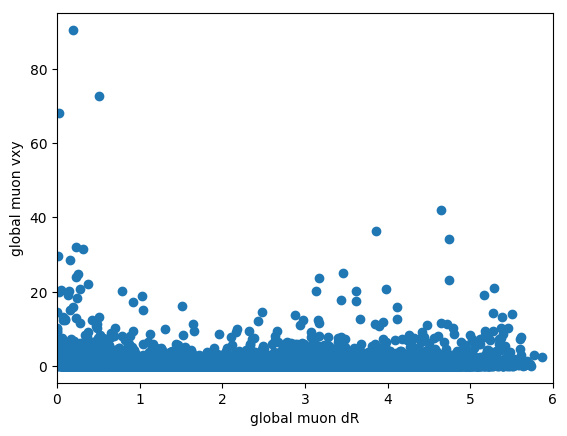

In [24]:
plt.scatter(objects[list(objects.keys())[0]]['vertex']['recoDr'], 
            objects[list(objects.keys())[0]]['vertex']['recoVxy'])
plt.xlim([0,6])
plt.xlabel('global muon dR')
plt.ylabel('global muon vxy')

In [27]:
num_cores = multiprocessing.cpu_count()

# Helper functions to calculate average angles
# This takes a few seconds to run, since we
# are using the apply method

def parallelize(data, func):
#     data_split = np.array_split(data, partitions)
    pool = multiprocessing.Pool(int(num_cores/2))
#     data = pd.concat(pool.map(func, data_split))
    data = pd.concat(pool.map(func, [group for name, group in data]))
    pool.close()
    pool.join()
    return data

def calcAvgAngle(group):
    # FIXME need to ensure at least 2 muons (otherwise index -1 == 0)
    x = np.cos(group['recoPhi'].iloc[0]) + np.cos(group['recoPhi'].iloc[-1])
    y = np.sin(group['recoPhi'].iloc[0]) + np.sin(group['recoPhi'].iloc[-1])
    return math.atan2(y/2, x/2)

def func_group_apply(df):
    # Applies above function on event-by-event basis
    return df.groupby('entry').apply(calcAvgAngle)

def reducephi(row):
    # Helper function to normalize angle differences to [-Pi, Pi]
    # cond: if abs(phidiff) > Pi => phidiff = phidiff - 2*Pi*sign(phidiff)
    if abs(row) > math.pi:
        return row - 2*math.pi*(row/abs(row))
    return row

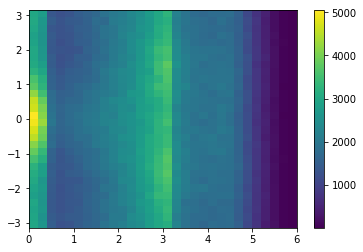

In [242]:
total = None
for i in np.arange(82):
    
    muons = objects[list(objects.keys())[i]]['muons'].reset_index()
    muons['data_chunk'] = muons['entry'].mod(int(num_cores * 3 / 2)) # num_cores/2 * 3 chunks/core
    muons = muons.set_index(['entry'])
    # Here, group by data_chunk instead of entry, inside func_group_apply
    # we also have a groupby('entry')
    avg_muon_angle = parallelize(muons.groupby('data_chunk'), func_group_apply)
    angle_diff = (objects[list(objects.keys())[i]]['MET']['recoPFMetPhi'].dropna() - avg_muon_angle).dropna()
    reduced_angle_diff = angle_diff.apply(reducephi).dropna()
    reduced_angle_diff.name = 'reducedAngleDiff'

    test_df = pd.concat([reduced_angle_diff, objects[list(objects.keys())[i]]['vertex']['recoDr']], axis=1).dropna()
    test = compute_hist2d(test_df, 'reducedAngleDiff', 'recoDr');
    if total is None:
        total = test[0][0]
    else:
        total += test[0][0]
    
plot_binned_data_2d(plt, test[0][2], test[0][1], total);
plt.colorbar()

Text(0,0.5,'$\\Delta\\Phi$(MET, muons)')

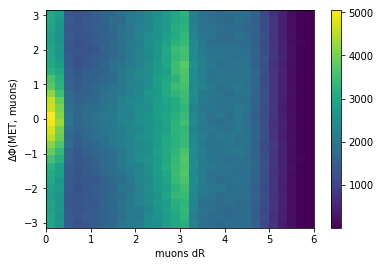

In [249]:
total = None
for i in np.arange(82):
    
    muons = objects[list(objects.keys())[i]]['muons'].reset_index()
    muons['data_chunk'] = muons['entry'].mod(int(num_cores * 3 / 2)) # num_cores/2 * 3 chunks/core
    muons = muons.set_index(['entry'])
    # Here, group by data_chunk instead of entry, inside func_group_apply
    # we also have a groupby('entry')
    avg_muon_angle = parallelize(muons.groupby('data_chunk'), func_group_apply)
    angle_diff = (objects[list(objects.keys())[i]]['MET']['recoPFMetPhi'].dropna() - avg_muon_angle).dropna()
    reduced_angle_diff = angle_diff.apply(reducephi).dropna()
    reduced_angle_diff.name = 'reducedAngleDiff'

    test_df = pd.concat([reduced_angle_diff, objects[list(objects.keys())[i]]['vertex']['recoDr']], axis=1).dropna()
    test = compute_hist2d(test_df, 'reducedAngleDiff', 'recoDr');
    if total is None:
        total = test[0][0]
    else:
        total += test[0][0]
    
plot_binned_data_2d(plt, test[0][2], test[0][1], total);
plt.colorbar()
plt.xlabel('muons dR')
plt.ylabel(r'$\Delta\Phi$(MET, muons)')

Text(0,0.5,'$\\Delta\\Phi$(MET, muons)')

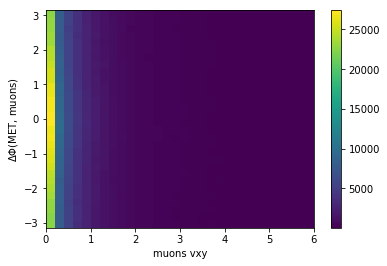

In [251]:
total = None
for i in np.arange(82):
    
    muons = objects[list(objects.keys())[i]]['muons'].reset_index()
    muons['data_chunk'] = muons['entry'].mod(int(num_cores * 3 / 2)) # num_cores/2 * 3 chunks/core
    muons = muons.set_index(['entry'])
    # Here, group by data_chunk instead of entry, inside func_group_apply
    # we also have a groupby('entry')
    avg_muon_angle = parallelize(muons.groupby('data_chunk'), func_group_apply)
    angle_diff = (objects[list(objects.keys())[i]]['MET']['recoPFMetPhi'].dropna() - avg_muon_angle).dropna()
    reduced_angle_diff = angle_diff.apply(reducephi).dropna()
    reduced_angle_diff.name = 'reducedAngleDiff'

    test_df = pd.concat([reduced_angle_diff, objects[list(objects.keys())[i]]['vertex']['recoVxy']], axis=1).dropna()
    test = compute_hist2d(test_df, 'reducedAngleDiff', 'recoVxy');
    if total is None:
        total = test[0][0]
    else:
        total += test[0][0]
    
plot_binned_data_2d(plt, test[0][2], test[0][1], total);
plt.colorbar()
plt.xlabel('muons vxy')
plt.ylabel(r'$\Delta\Phi$(MET, muons)')

In [101]:
def compute_hist2d(variables_df, var_name1, var_name2, **kwargs):
        # Given a dataframe for some observable, adds the
        # gen weight and computes the histogram for it
        if 'bins' not in kwargs:
            kwargs['bins'] = 30
            kwargs['range'] = ((-math.pi,math.pi), (0,6))
#         temp_df = pd.concat([variables_df, self.genwgt], axis=1).dropna()
#         temp_df['genwgt_sqrd'] = temp_df['genwgt']**2
        counts = {}; edges_x = {}; edges_y = {}; wgt_sqrd = {}
        for cut in numCuts:
#             cuts_to_apply = slice(None) if self.cuts_crit is None else reduce(operator.and_, self.cuts_crit[0:cut+1])
#             kwargs['weights'] = temp_df[cuts_to_apply]['genwgt']
            counts[cut], edges_x[cut], edges_y[cut] = np.histogram2d(variables_df[var_name1], variables_df[var_name2], **kwargs)
            # Digitizes data to find out which bin of histogram each row falls in
#             bin_idxs = np.digitize(temp_df[cuts_to_apply][variable_df.name], edges[cut])
#             temp_df['bin_idx'] = pd.Series(bin_idxs)
            # Uses indexes from above to sum the gen weights squared (for errors)
#             wgt_sqrd[cut] = np.sum(temp_df.groupby('bin_idx'))['genwgt_sqrd']
        return list(zip(counts.values(), edges_x.values(), edges_y.values()))#, wgt_sqrd.values()))

In [226]:
test_df = pd.concat([reduced_angle_diff, objects[list(objects.keys())[0]]['vertex']['recoDr']], axis=1).dropna()
test = compute_hist2d(test_df, 'reducedAngleDiff', 'recoDr');

In [228]:
def plot_binned_data_2d(axis, bin_edges_x, bin_edges_y, data, *args, **kwargs):
    #The dataset values are the bin centres
    x = (bin_edges_x[1:] + bin_edges_x[:-1]) / 2.0
    y = (bin_edges_y[1:] + bin_edges_y[:-1]) / 2.0
    X, Y = np.meshgrid(x, y)
    
#     print(len(x), len(y), len(data[0]))
    #The weights are the y-values of the input binned data
    weights = data.flatten()
    return axis.hist2d(x=X.flatten(), y=Y.flatten(), bins=[bin_edges_x,bin_edges_y], weights=weights, *args, **kwargs) 

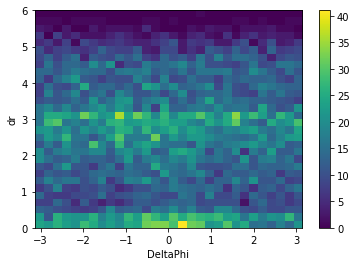

In [141]:
plt.hist2d(y=test_df['recoDr'], x=test_df['reducedAngleDiff'], bins=30, range=((-math.pi,math.pi),(0,6)))
plt.ylabel('dr')
plt.xlabel('DeltaPhi')
plt.colorbar()

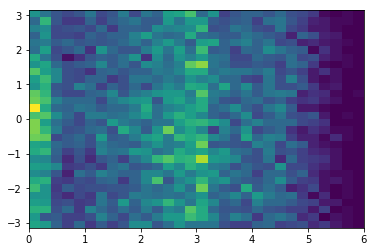

In [227]:
plt.hist2d(x=X.flatten(), y=Y.flatten(), bins=[test[0][2],test[0][1]], weights=test[0][0].flatten());

In [217]:
X, Y = np.meshgrid((test[0][2][1:] + test[0][2][:-1])/2.0, (test[0][1][1:] + test[0][1][:-1])/2.0);

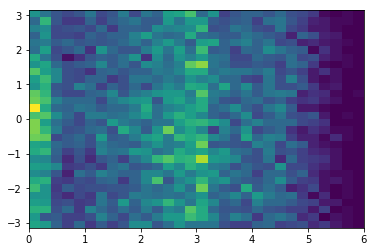

In [229]:
plot_binned_data_2d(plt, test[0][2], test[0][1], test[0][0]);

In [77]:
test[0][0]

array([[4., 2., 1., ..., 1., 4., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 5., 3., ..., 1., 3., 1.],
       [2., 3., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

(0, 6)

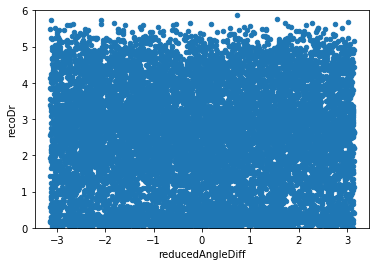

In [88]:
test_df.plot.scatter(x='reducedAngleDiff', y='recoDr')
plt.ylim([0,6])

(0, 6)

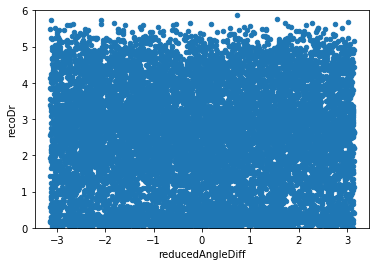

In [45]:
pd.concat([reduced_angle_diff, objects[list(objects.keys())[0]]['vertex']['recoDr']], 
          axis=1).dropna().plot.scatter(x='reducedAngleDiff', y='recoDr')
plt.ylim([0,6])

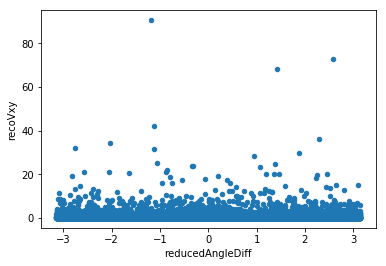

In [47]:
pd.concat([reduced_angle_diff, objects[list(objects.keys())[0]]['vertex']['recoVxy']], 
          axis=1).dropna().plot.scatter(x='reducedAngleDiff', y='recoVxy')

## Make plots

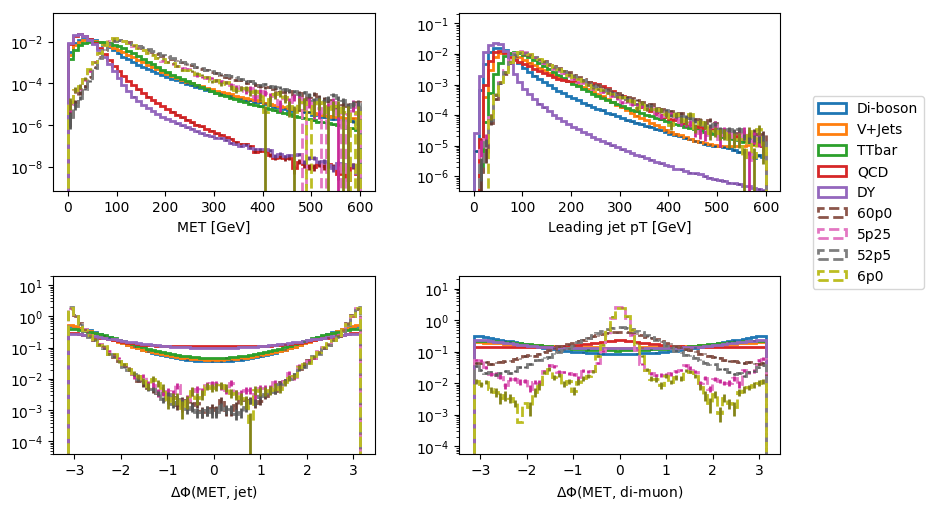

In [34]:
plt_maker = PM.PlotMaker(histos)

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_metjet):
    plt_maker.make_group_plot(axes1.flatten()[idx], var, bkg_grps, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
axes1[0,1].legend(loc=(1.1,-0.55));

(0, 500000)

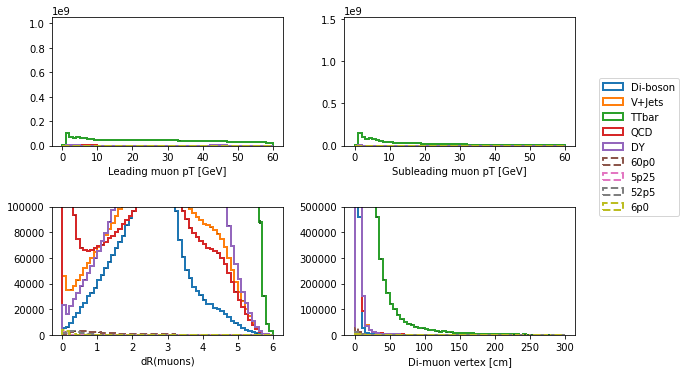

In [56]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_muons):
    plt_maker.make_group_plot(axes2.flatten()[idx], var, bkg_grps, 0, log=False, density=False)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
axes2[0,1].legend(loc=(1.1,-0.55));
axes2[1,0].set_ylim([0,100000])
axes2[1,1].set_ylim([0,500000])

In [ ]:
histos['recodr']['QCD']

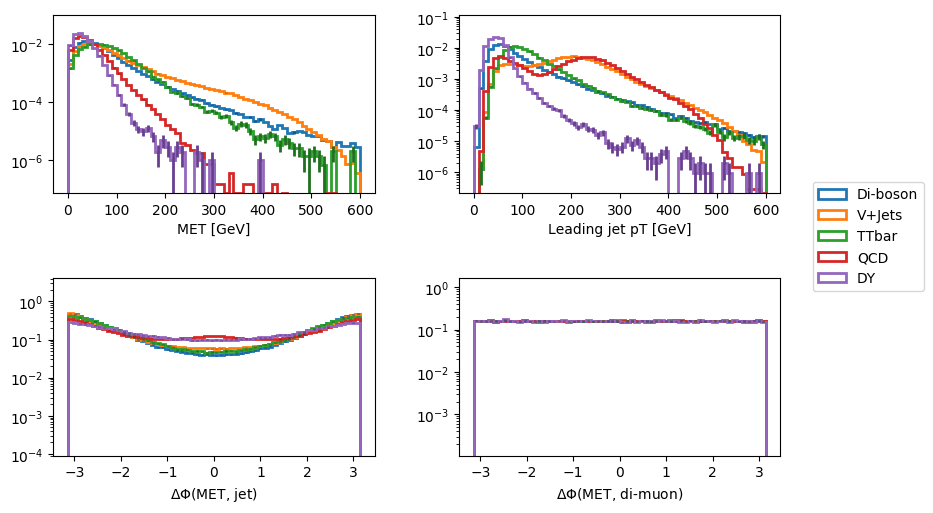

In [1155]:
fig1, axes1 = plt.subplots(2,2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)
for var in allplotvars1:
    make_plot(var, axes1.flatten()[allplotvars1.index(var)], plot_groups=True, density=True, log=True)
axes1[0,1].legend(loc=(1.1,-0.55));

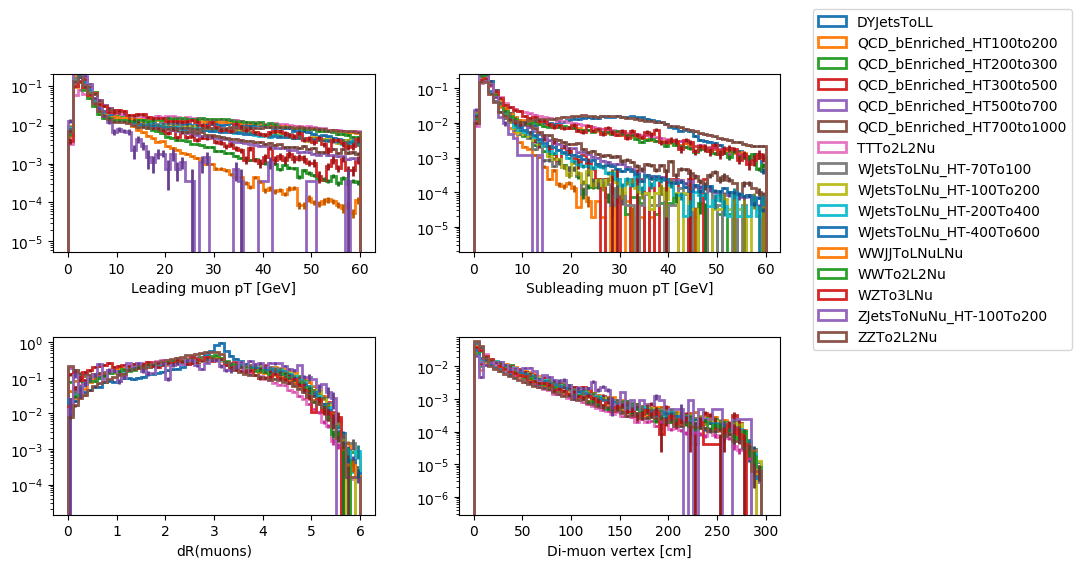

In [1158]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for var in allplotvars2:
    make_plot(var, axes2.flatten()[allplotvars2.index(var)], plot_groups=False, density=True, log=True)
axes2[0,1].legend(loc=(1.1,-0.55));